In [2]:
import numpy as np
import torch
import torch.optim as optim
import model
import utils
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
import os
from dataset import DataSet
import warnings
warnings.simplefilter('ignore', np.RankWarning) # set warning for polynomial fitting


In [302]:
lcs = DataSet(name='./ZTF_DR_data', min_length=50, sep=',', start_col=1)

In [303]:
lcs.add_band('g', os.path.join('./ZTF_DR_data', 'g'))
lcs.add_band('i', os.path.join('./ZTF_DR_data', 'i'))

validated 3398 files out of 3398 for band='g'
validated 3399 files out of 3399 for band='i'


## Visualize the masks

validated 3398 files out of 3398 for band='r'
validated 3399 files out of 3399 for band='i'
validated 3398 files out of 3398 for band='g'


/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1545: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


created union_tp attribute of length 100310
dataset created w/ shape (2070, 3, 4262, 3)
train size: 1656, valid size: 332, test size: 414


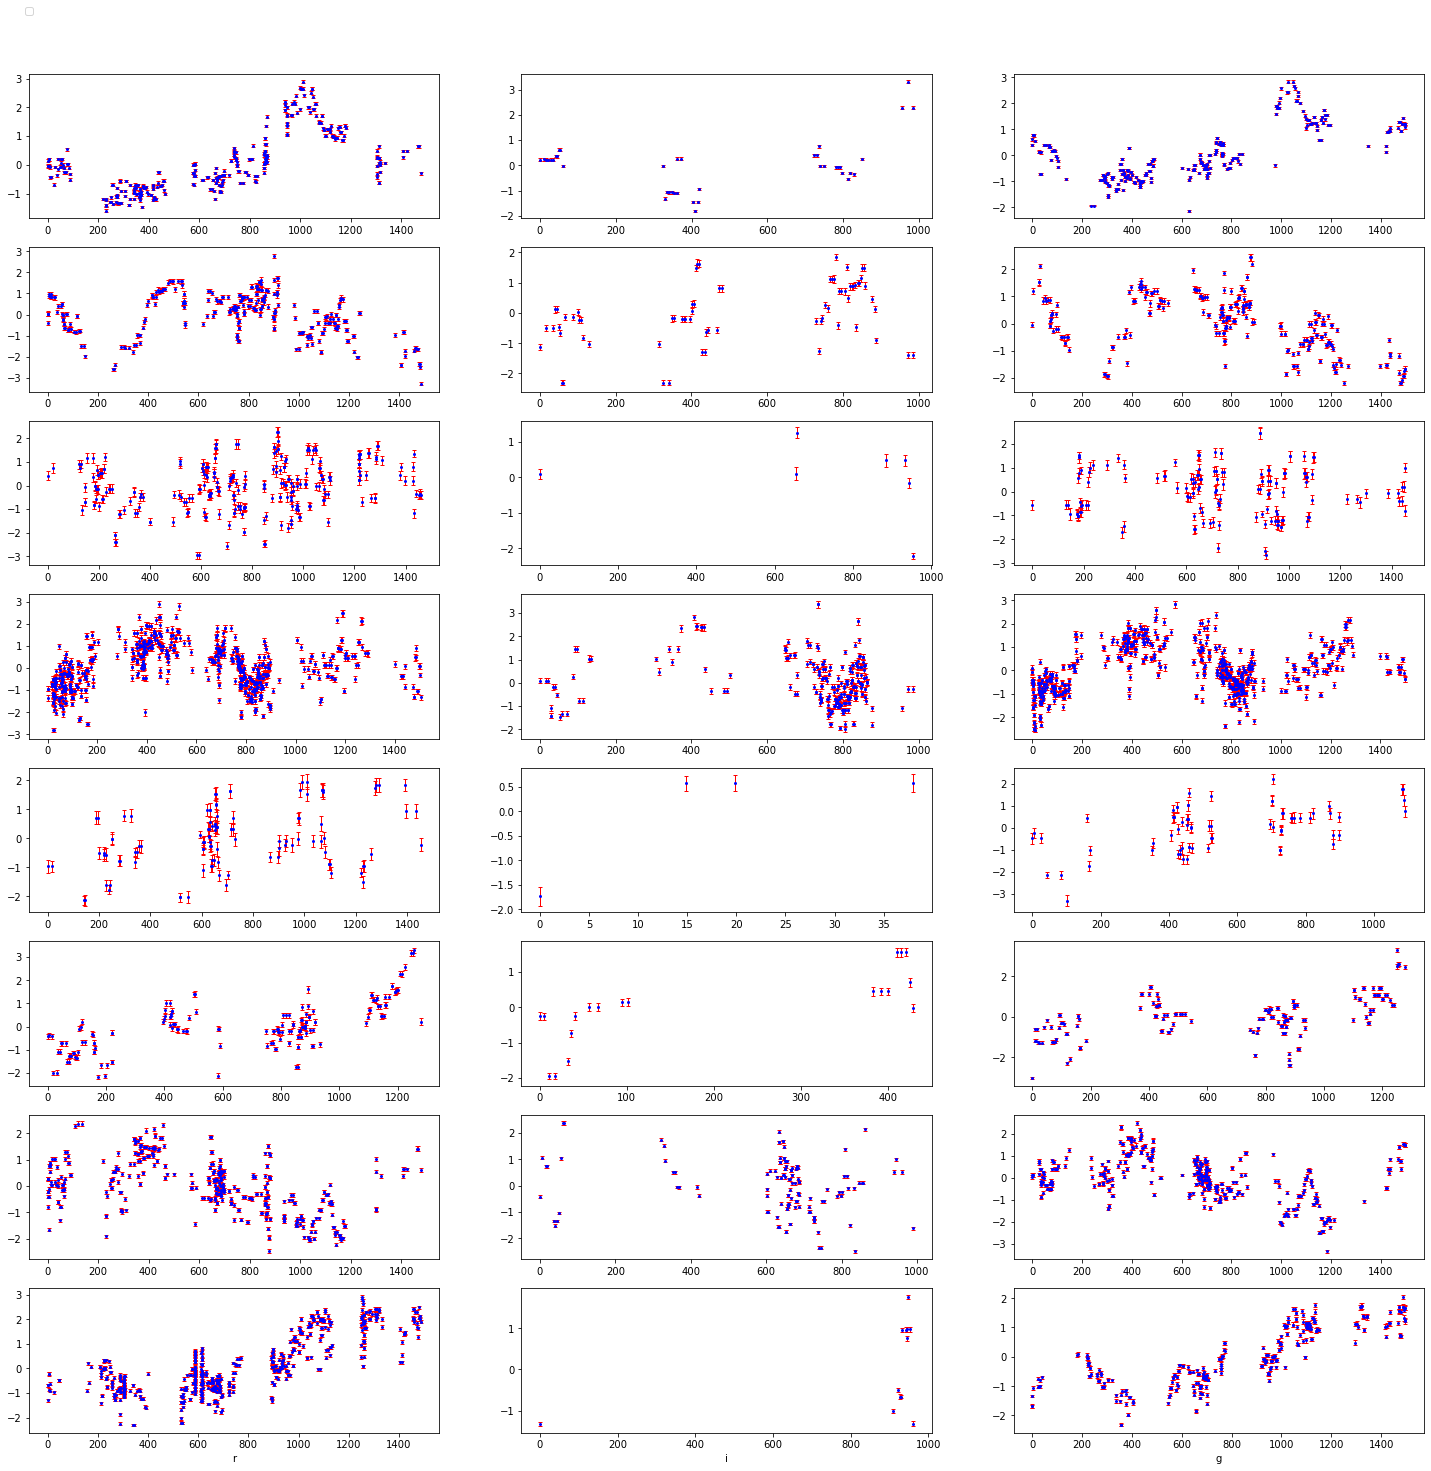

In [317]:
ZTF = utils.get_data(start_col=1, folder='./ZTF_DR_data', min_length=100)
ZTF.set_target_x(num_points=400)
#net, optimizer, args, epoch, loss =  utils.load_checkpoint('synth_4039110.h5', ZTF.data_obj)
utils.preview_lcs(ZTF.data_obj['train_loader'], ZTF.bands, N=8, figsize=(25,25))

In [146]:
ZTF.dataset.shape

(2524, 1, 2102, 3)

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   4.,  17.,  62., 180., 561.,
        702., 359., 221., 132.,  75.,  47.,  31.,  27.,  30.,  15.,  17.,
          7.,   3.,   3.,   7.,   2.,   3.,   5.,   1.,   4.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.42513387, -0.41734294, -0.409552  , -0.40176107, -0.39397013,
        -0.3861792 , -0.37838826, -0.37059733, -0.36280639, -0.35501546,
        -0.34722452, -0.33943359, -0.33164265, -0.32385172, -0.31606078,
        -0.30826985, -0.30047891, -0.29268798, -0.28489704, -0.27710611,
        -0.26931517, -0.26

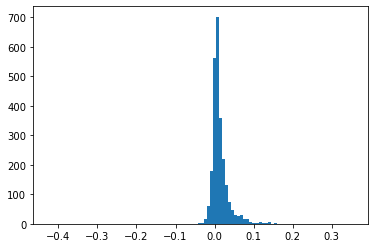

In [73]:
plt.hist(ZTF.intrinsic_vars, 100)

## Visualize LR

Text(0, 0.5, 'lr')

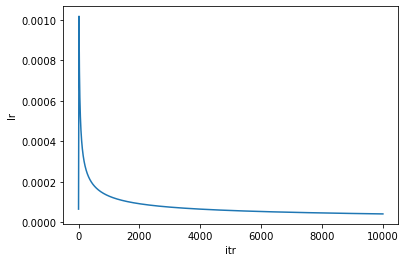

In [133]:
model_size = utils.count_parameters(net)
warmup = args.warmup
plt.plot([utils.update_lr(model_size, itr, 4000) for itr in range(1,10000)])
plt.xlabel('itr')
plt.ylabel('lr')

In [128]:
def predict(dataloader, device='mps', k_iwae=2, subsample=False, target_x=None, plot=True, figsize=(25,15)):
    pred_mean, pred_std = [], []
    qz_mean, qz_std = [], []
    masks = []
    targets = []
    tp =[]
    target_tp = []
    np.random.seed(0)
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            
            batch_len = batch.shape[0]
            if subsample == True:
                subsampled_mask = utils.make_masks(batch, frac=0.5)
            else:
                subsampled_mask = utils.make_masks(batch, frac=1.0)
            batch = batch.to(device)
            subsampled_mask = subsampled_mask.to(device)
            recon_mask = torch.logical_xor(batch[:,:,:,1], subsampled_mask)
            context_y = torch.cat((batch[:,:,:,1] * subsampled_mask, subsampled_mask), 1).transpose(2,1)
            recon_context_y=torch.cat((batch[:,:,:,1] * recon_mask, recon_mask), 1).transpose(2,1)
            
            if target_x is not None:
                tx = torch.tensor(target_x[i*batch_len:(i*batch_len + batch_len)])[:,0]
            else:
                tx = batch[:, 0, :,0]
            px, qz = net.get_reconstruction(batch[:, 0, :,0], context_y, tx, num_samples=k_iwae)
            
            pred_mean.append(px.mean.cpu().numpy())
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            qz_mean.append(qz.mean.cpu().numpy())
            qz_std.append(torch.exp(0.5 * qz.logvar).cpu().numpy())
            
            targets.append((batch[:, :, :,1]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, 0, :,0].cpu().numpy())
            target_tp.append(tx.cpu().numpy())
      
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    qz_mean = np.concatenate(qz_mean, axis=0)
    qz_std = np.concatenate(qz_std, axis=0)
    
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    target_tp = np.concatenate(target_tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    inputs = np.transpose(inputs, [0,2,1])
    # reparam trick
    preds = np.random.randn(k_iwae//2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    
    qz_preds = np.random.randn(k_iwae//2, k_iwae, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2]) * qz_std + qz_mean
    qz_preds = qz_preds.reshape(-1, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2])
    qz_median = preds.mean(0)
    if plot == True:
       
        median = preds.mean(0)
        quantile2 = np.quantile(preds, 0.841, axis=0)
        quantile1 = np.quantile(preds, 0.159, axis=0)

        fig,ax = plt.subplots(5,1,figsize=figsize)
        for i in range(1):
            #### remove padding and masked vals
            nonzero_pred = target_tp[i].nonzero()[0]
            nonzero_in = inputs[i].nonzero()[0]
            
            ax[i].fill_between(target_tp[i,nonzero_pred], quantile1[i,nonzero_pred,0], quantile2[i,nonzero_pred,0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            ax[i].plot(target_tp[i, nonzero_pred], median[i, nonzero_pred])
            ax[i].scatter(tp[i, nonzero_in], inputs[i, nonzero_in])
        
    return preds, qz_preds, tp, target_tp, inputs 


In [ ]:
preds, qz_preds, tp, target_tp, inputs = predict(ZTF.data_obj['train_loader'], subsample=True)

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


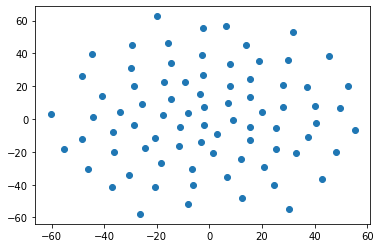

In [10]:
RS = 20150101
latent = latent.reshape((len(latent), -1))
proj = TSNE(random_state=RS).fit_transform(latent)
plt.scatter(proj[:,0], proj[:,1])